# Forecasting Weather with LSTM Recurrent Neural Networks (12)
## 1 . Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)


#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


In [2]:
import numpy
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [200]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    data, dataX, dataY = [], [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

## 2. Extracting Data and Transforming Data

In [185]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

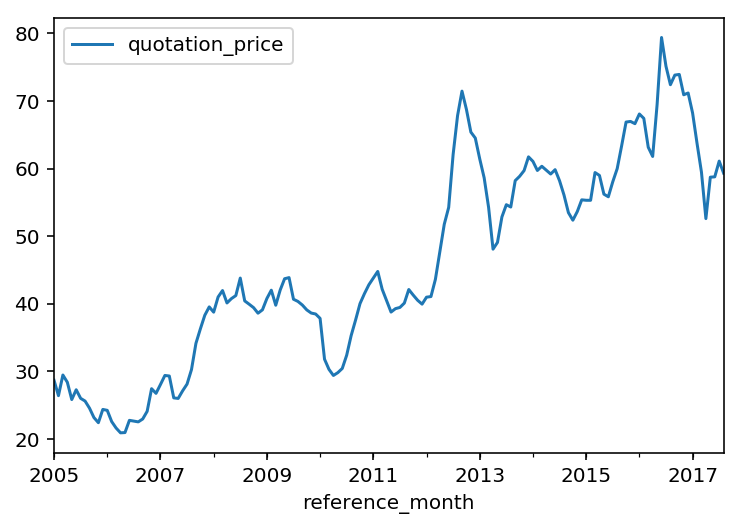

In [186]:
# Extrai dados Climáticos da Estação Selecionada
quotation = list(db.quotation_monthlies.find({'federal_unit_id': ObjectId('59867b535718ddc0b8efd9a0'),'product_id': ObjectId('59867b705718ddc1160a5ec0')}))
quotation_normalized = pd.io.json.json_normalize(quotation)
df_quotation = pd.DataFrame(quotation_normalized[['reference_month', 'quotation_price']])
df_quotation = df_quotation.set_index('reference_month')
ts_quotation = df_quotation['2000-01-01':'2017-08-01'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_quotation = ts_quotation.asfreq(freq='MS', method='bfill')
ts_quotation = ts_quotation[ts_quotation.index >= '2005-01-01']
ts_quotation.head()
ts_quotation.plot()

In [187]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [363]:
dataset = ts_quotation.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [364]:
look_back = 3
forecasting = 3
# split into train and test sets
test_size = look_back + forecasting
train_size = int(len(dataset) - test_size)
train, test = dataset[0:train_size+look_back,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

149 6


In [365]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [366]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [205]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0560
Epoch 2/100
 - 0s - loss: 0.0148
Epoch 3/100
 - 0s - loss: 0.0093
Epoch 4/100
 - 0s - loss: 0.0063
Epoch 5/100
 - 0s - loss: 0.0045
Epoch 6/100
 - 0s - loss: 0.0039
Epoch 7/100
 - 0s - loss: 0.0036
Epoch 8/100
 - 0s - loss: 0.0034
Epoch 9/100
 - 0s - loss: 0.0035
Epoch 10/100
 - 0s - loss: 0.0034
Epoch 11/100
 - 0s - loss: 0.0034
Epoch 12/100
 - 0s - loss: 0.0034
Epoch 13/100
 - 0s - loss: 0.0034
Epoch 14/100
 - 0s - loss: 0.0033
Epoch 15/100
 - 0s - loss: 0.0034
Epoch 16/100
 - 0s - loss: 0.0032
Epoch 17/100
 - 0s - loss: 0.0033
Epoch 18/100
 - 0s - loss: 0.0031
Epoch 19/100
 - 0s - loss: 0.0033
Epoch 20/100
 - 0s - loss: 0.0032
Epoch 21/100
 - 0s - loss: 0.0031
Epoch 22/100
 - 0s - loss: 0.0031
Epoch 23/100
 - 0s - loss: 0.0030
Epoch 24/100
 - 0s - loss: 0.0030
Epoch 25/100
 - 0s - loss: 0.0030
Epoch 26/100
 - 0s - loss: 0.0029
Epoch 27/100
 - 0s - loss: 0.0029
Epoch 28/100
 - 0s - loss: 0.0028
Epoch 29/100
 - 0s - loss: 0.0028
Epoch 30/100
 - 0s - lo

In [367]:
testX = numpy.reshape(testX[0], (testX[0].shape[0], 1, testX[0].shape[1]))
testPredict1 = model.predict(testX)

testX =numpy.array([[testX[0][0][1],testX[0][0][2],testPredict1[0][0]]])
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testPredict2 = model.predict(testX)

testX =numpy.array([[testX[0][0][1],testX[0][0][2],testPredict2[0][0]]])
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testPredict3 = model.predict(testX)

testPredict = numpy.array([testPredict1[0],testPredict2[0],testPredict3[0]])
testPredict

array([[ 0.65174711],
       [ 0.66721898],
       [ 0.67366773]], dtype=float32)

In [368]:
# make predictions
trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

In [369]:
trainPredict

array([[ 0.14608628],
       [ 0.1377636 ],
       [ 0.08952081],
       [ 0.10930568],
       [ 0.09528664],
       [ 0.08422006],
       [ 0.0684589 ],
       [ 0.04515181],
       [ 0.03199046],
       [ 0.06252335],
       [ 0.06564032],
       [ 0.03702401],
       [ 0.01920997],
       [ 0.00876204],
       [ 0.00906033],
       [ 0.03725445],
       [ 0.03926749],
       [ 0.03506629],
       [ 0.04155158],
       [ 0.06010753],
       [ 0.1156145 ],
       [ 0.10997263],
       [ 0.12517396],
       [ 0.15110639],
       [ 0.15063462],
       [ 0.09539311],
       [ 0.08771382],
       [ 0.11028616],
       [ 0.12911007],
       [ 0.16536671],
       [ 0.23482329],
       [ 0.27641568],
       [ 0.3097721 ],
       [ 0.33155963],
       [ 0.3161661 ],
       [ 0.35320368],
       [ 0.37469402],
       [ 0.33920658],
       [ 0.34668735],
       [ 0.35876867],
       [ 0.40490854],
       [ 0.34660566],
       [ 0.32911679],
       [ 0.32510141],
       [ 0.31054816],
       [ 0

In [370]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [371]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: 2.42266 RMSE
Test Score: 0.89541 RMSE


In [372]:
# shift train for plotting
trainPlot = scaler.inverse_transform(dataset[:len(trainPredict)+look_back])

In [373]:
# shift test for plotting
testPlot = numpy.empty_like(dataset)
testPlot[:, :] = numpy.nan
testPlot[len(trainPredict)+look_back:len(dataset), :] = scaler.inverse_transform(dataset[len(trainPredict)+look_back:len(dataset)])

In [374]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:len(dataset)-forecasting])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [375]:
trainPredictPlot.shape

(149, 1)

In [376]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[len(trainPredictPlot):len(dataset)])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[:len(dataset), :] = testPredict

In [377]:
len(testPredictPlot)

3

In [378]:
Predict = numpy.append(trainPredictPlot, testPredictPlot)
Predict

array([         nan,          nan,          nan,  29.44717216,
        28.96041489,  26.13889694,  27.29603004,  26.47611618,
        25.8288765 ,  24.90707397,  23.54393959,  22.77418709,
        24.55992889,  24.74222755,  23.06857872,  22.02671051,
        21.41565323,  21.43309975,  23.08205605,  23.19978905,
        22.95408058,  23.33337784,  24.41863632,  27.66500664,
        27.33503723,  28.22409821,  29.74077606,  29.71318817,
        26.48234367,  26.03321457,  27.35337448,  28.45430565,
        30.57480431,  34.63702774,  37.06959534,  39.02047348,
        40.29473114,  39.39442825,  41.56060028,  42.81747818,
        40.74197006,  41.17948532,  41.88607407,  44.58460236,
        41.17470932,  40.1518631 ,  39.91701508,  39.06586075,
        39.56893158,  41.44056702,  42.82258987,  40.41938782,
        42.4837265 ,  44.63235474,  44.69983673,  41.18358612,
        40.59607315,  40.32871628,  39.56245041,  39.07214737,
        38.95432281,  38.31554794,  32.11124802,  30.07

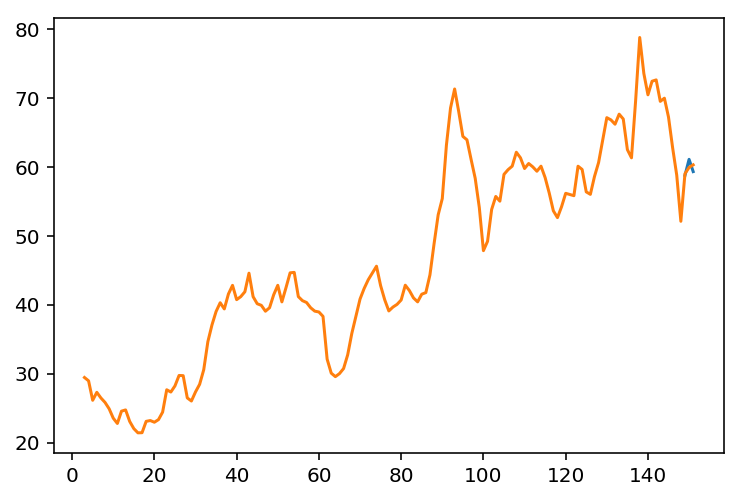

In [379]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1]))
#plt.plot(trainPlot)
plt.plot(testPlot)
plt.plot(Predict)
plt.show()

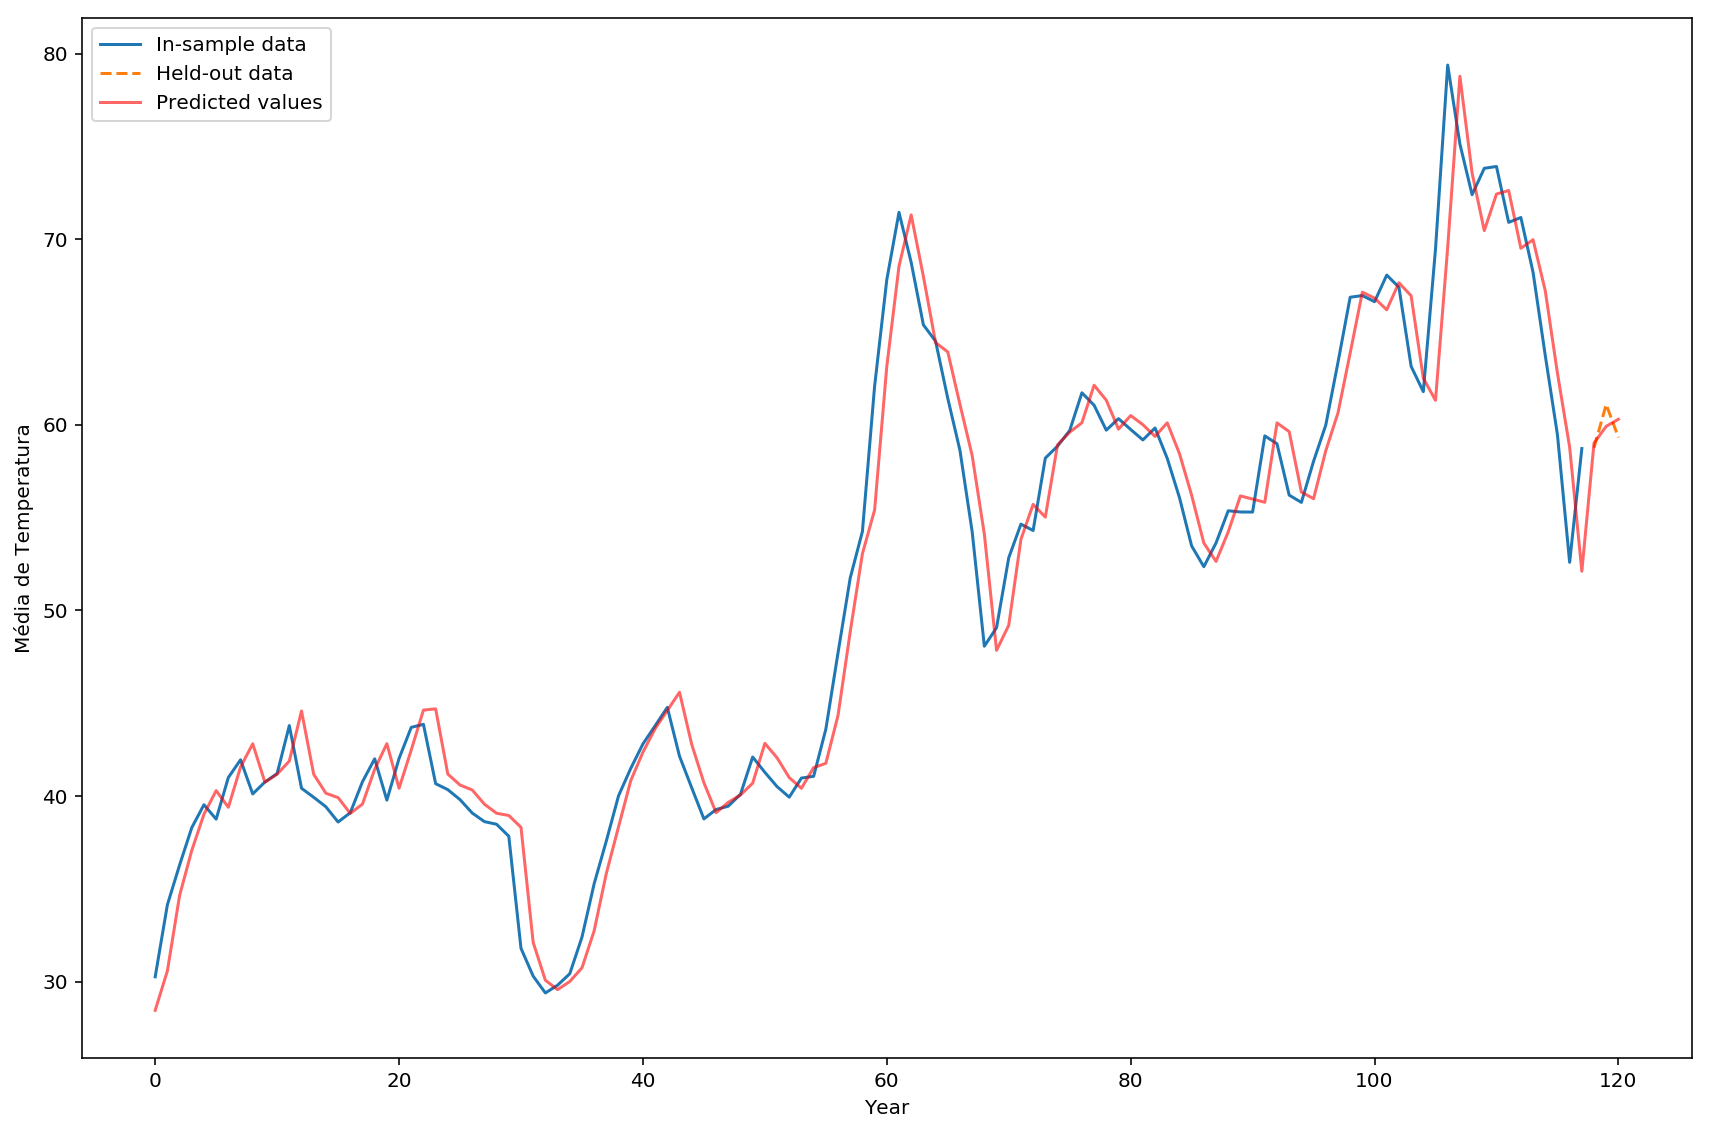

In [380]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(trainPlot[len(dataset)-121:], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(testPlot[len(dataset)-121:], label='Held-out data', linestyle='--')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(Predict[len(dataset)-121:], 'r', alpha=.6, label='Predicted values')

ax1.set_xlabel("Year")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

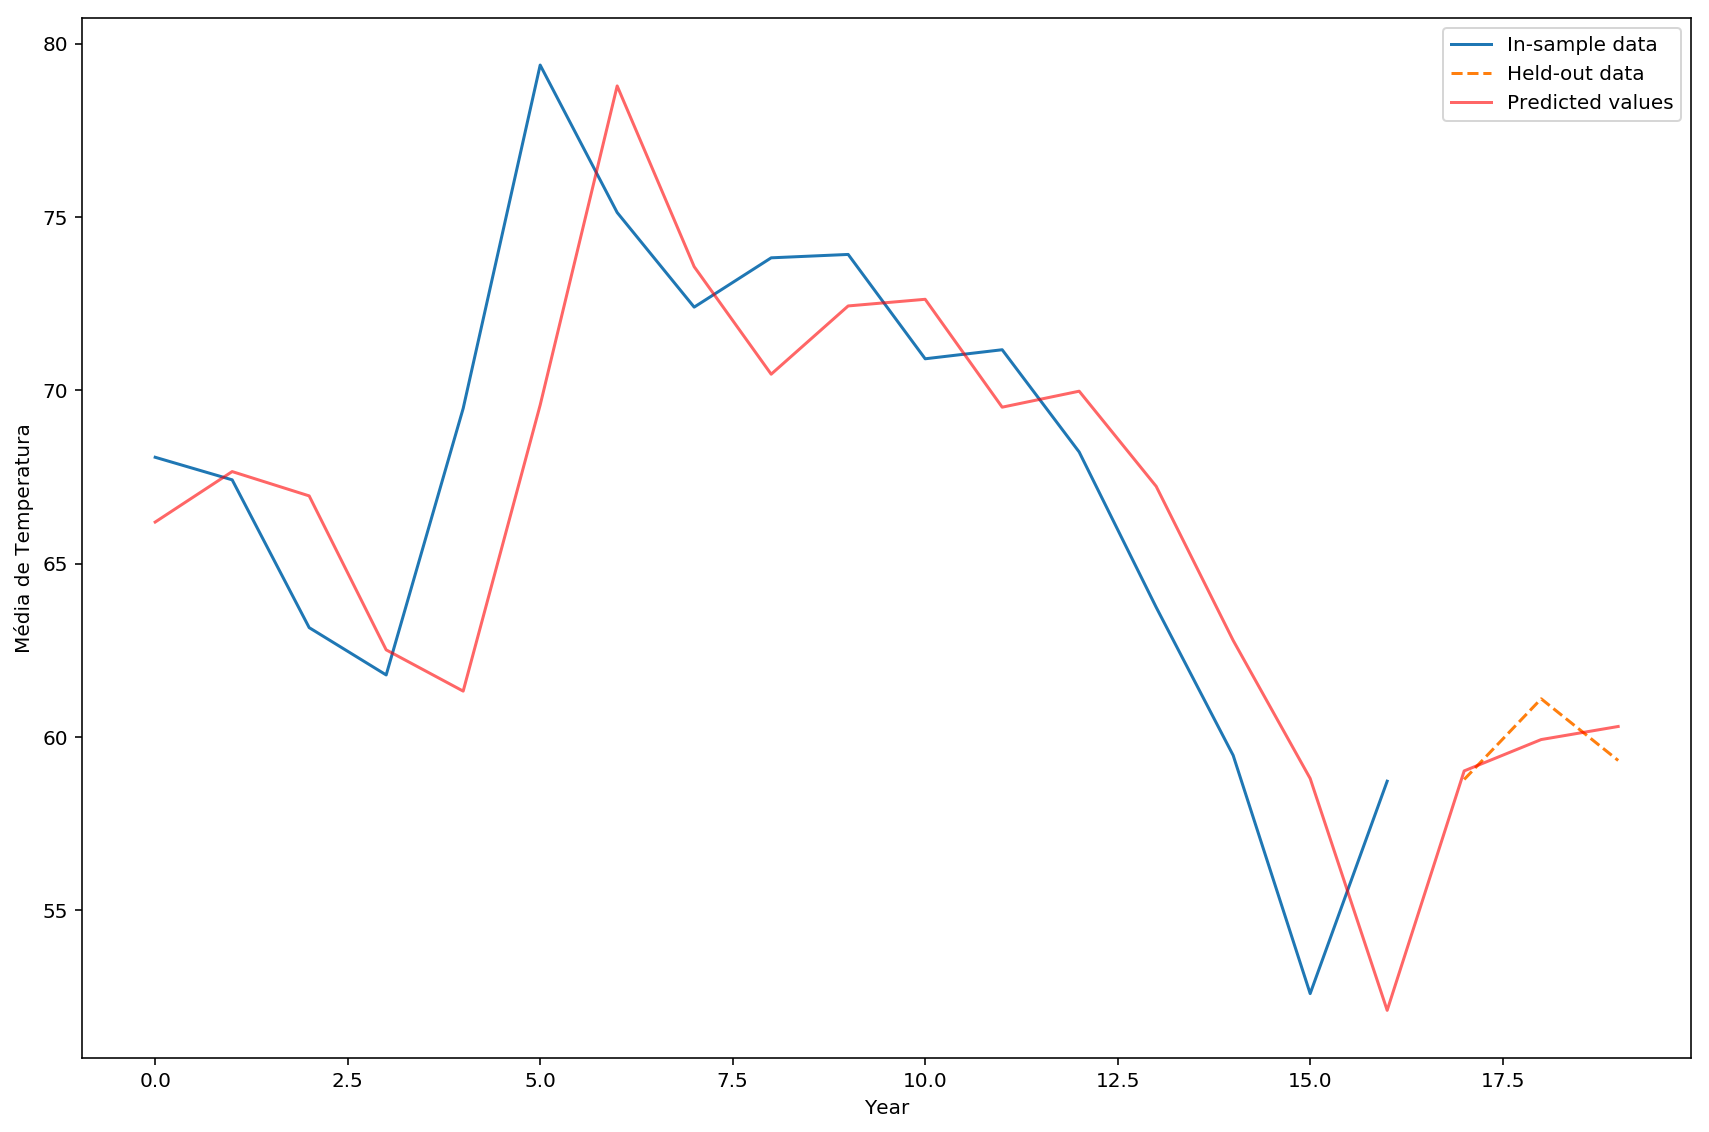

In [383]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(trainPlot[len(dataset)-20:], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(testPlot[len(dataset)-20:], label='Held-out data', linestyle='--')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(Predict[len(dataset)-20:], 'r', alpha=.6, label='Predicted values')

ax1.set_xlabel("Year")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

In [29]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

In [30]:
# Training Set

rmse = get_rmse(trainY[0], trainPredict[:,0])
print("RMSE: ", rmse)

mape = get_mape(trainY[0], trainPredict[:,0])
print("MAPE: ", mape)

RMSE:  1.10370545581
MAPE:  4.28812312135


In [31]:
# Test Set

rmse = get_rmse(testY[0], testPredict[:,0])
print("RMSE: ", rmse)

mape = get_mape(testY[0], testPredict[:,0])
print("MAPE: ", mape)

RMSE:  0.850960037812
MAPE:  3.59452218239
